<div style="
    color: blue; /* Text color */
    background-color: #f0f0f0; /* Light grey background */
    font-family: 'Pacifico', cursive; /* Stylish font */
    font-size: 40px; /* Font size */
    font-weight: bold; /* Bold text */
    padding: 20px; /* Padding around the text */
    border: 2px solid #ccc; /* Border with a light grey color */
    border-radius: 10px; /* Rounded corners */
    text-align: center; /* Centered text */
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); /* Subtle shadow */
    position: relative; /* Required for pseudo-elements positioning */
    display: inline-block; /* Inline-block for proper spacing */
">
    <span style="
        position: absolute; /* Absolute positioning */
        left: -40px; /* Positioning arrow on the left */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
    NN Modeling
    <span style="
        position: absolute; /* Absolute positioning */
        right: -40px; /* Positioning arrow on the right */
        top: 50%; /* Vertically center */
        transform: translateY(-50%); /* Adjust vertical alignment */
        font-size: 30px; /* Arrow size */
        color: red; /* Arrow color */
    ">➤</span>
</div>

<link href="https://fonts.googleapis.com/css2?family=Pacifico&display=swap" rel="stylesheet">


In [149]:
# pip install tensorflow


In [150]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
prediction_days_count = 2

def get_X_Y (exception_countries = []):
    df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")

    # delete called countries:
    for iso_code in exception_countries:
        df = df[df["iso_code"] != iso_code]
    df = df.reset_index(drop=True)

    country_num = int(len(df["iso_code"].unique()))

    df.drop(["iso_code", "week_no"], axis=1, inplace=True)
    #df.drop(columns=df.columns[0:1], axis=1, inplace=True)
    pop = df.iloc[0]["population"]
    last_country = df.iloc[country_num*176 - 1]
    print(last_country)
    cnt = df["population"].value_counts()

    # now we want to join datas together
    features_list = []
    X_list = []
    Y_list = []

    for i in range(country_num):  # 234 is number of countries
        for j in range(176):  # 176 is number of weeks we have
            row_list = df.loc[i * 176 + j, :].values.flatten().tolist()
            features_list.append(row_list)

    for i in range((len(features_list) - prediction_days_count) + 1):
        fl = features_list[i]
        fl_len = len(features_list[i])
        this_population = features_list[i][fl_len - 1]
        for j in range(1, prediction_days_count):
            if this_population == features_list[i + j][fl_len - 1]:
                fl.extend(features_list[i + j])
            else:
                this_population = -1
                break
        if this_population != -1:
            X_list.append(fl)
            Y_list.append(features_list[(i + prediction_days_count) - 1][0])

    return X_list, Y_list, country_num

In [152]:
import math

def train_test_splitter(X, Y, country_num, prediction_days_count, batch_count, batch_length):
    xlen = len(X)
    xs_count_for_each_country = int(xlen / country_num)
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1))
    i = 0
    for i in range(country_num):
        j = 0
        for j in range((i * xs_count_for_each_country), (i * xs_count_for_each_country) + steps):
            X_train.append(X[j])
            Y_train.append(Y[j])
        while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
            for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                X_test.append(X[k])
                Y_test.append(Y[k])
            j += batch_length
            for k in range(j, j + steps):
                X_train.append(X[k])
                Y_train.append(Y[k])
            j += steps + 1
            while j < (i+1) * xs_count_for_each_country:
                X_train.append(X[j])
                Y_train.append(Y[j])
                j += 1
    return X_train, X_test, Y_train, Y_test

In [153]:
# getting data:
X_list, Y_list, country_num = get_X_Y(["CHN"])

new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41007, dtype: float64


In [154]:
x_df = pd.DataFrame(X_list)
min_max_scaler_X = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler_X.fit_transform(x_df)

y_df = pd.DataFrame(Y_list)
min_max_scaler_Y = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler_Y.fit_transform(y_df)

X_scaled_list = x_scaled.tolist()
Y_scaled_list = y_scaled.tolist()

In [155]:
X_train, X_test, Y_train, Y_test = train_test_splitter(X_scaled_list, Y_scaled_list,
                                                       country_num=country_num,
                                                       prediction_days_count=prediction_days_count,
                                                       batch_count=3,
                                                       batch_length=10)
X_tr = np.array(X_train)
y_tr = np.array(Y_train).reshape(len(Y_train))
X_te = np.array(X_test)
y_te = np.array(Y_test).reshape(len(Y_test))

In [156]:
min_val = min_max_scaler_Y.data_min_[0]
max_val = min_max_scaler_Y.data_max_[0]

In [157]:
from tensorflow.keras import backend as K

# Define the custom loss function


# Define the custom loss function
def rescale_data_tensor(data):
    return (data * (max_val - min_val) + min_val)/10 # you can delete /10 I put it because we add 10 people
                                                     # error

def loss_function(y_true, y_pred):
    # y_true = rescale_data_tensor(y_true)
    # y_pred = rescale_data_tensor(y_pred)
    return K.sqrt(K.mean(K.square(y_true - y_pred)))
    # return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [158]:
import tensorflow as tf
from tensorflow.keras import backend as K

class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='custom_accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Reshape y_true and y_pred to ensure they are 1-dimensional
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Mask for non-zero values
        non_zero_indices = tf.logical_and(tf.not_equal(y_true, 0), tf.not_equal(y_pred, 0))

        # Filter non-zero values
        y_true_non_zero = tf.boolean_mask(y_true, non_zero_indices)
        y_pred_non_zero = tf.boolean_mask(y_pred, non_zero_indices)

        # Calculate ratio
        ratio = y_true_non_zero / y_pred_non_zero

        # Check if ratio is within the acceptable range
        ok = tf.logical_and(ratio > 0.1, ratio < 10)

        # Calculate accuracy
        accurate = tf.reduce_sum(tf.cast(ok, tf.float32))
        total = tf.cast(tf.size(y_true_non_zero), tf.float32)

        self.total.assign_add(total)
        self.count.assign_add(accurate)

    def result(self):
        return self.count / self.total

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)


# First Model

In [159]:
modle_1 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [160]:
modle_1.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [161]:
modle_1.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 64)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
history1 = modle_1.fit(X_tr, y_tr, validation_split=0.25, epochs=50, batch_size=50)

Epoch 1/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - custom_accuracy: 0.1683 - loss: 0.0329 - val_custom_accuracy: 0.2732 - val_loss: 0.0180
Epoch 2/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - custom_accuracy: 0.2140 - loss: 0.0070 - val_custom_accuracy: 0.0731 - val_loss: 0.0226
Epoch 3/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - custom_accuracy: 0.2148 - loss: 0.0062 - val_custom_accuracy: 0.2781 - val_loss: 0.0198
Epoch 4/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - custom_accuracy: 0.2116 - loss: 0.0070 - val_custom_accuracy: 0.3525 - val_loss: 0.0172
Epoch 5/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - custom_accuracy: 0.2154 - loss: 0.0062 - val_custom_accuracy: 0.4015 - val_loss: 0.0157
Epoch 6/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - custom_accuracy: 0.2662 - loss: 0.0044 - val_custom_accuracy: 0.1789 - val_loss: 0.0157
Epoch 7/50
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - custom_accuracy: 0.2081 - loss: 0.0067 - val_custom_accuracy: 0.1484 - val_loss: 0

In [163]:
y_pred = modle_1.predict (X_te)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [164]:
loss_function(y_te, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.013765117590306866>

In [165]:
accuracy1 = CustomAccuracy()
accuracy1.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {accuracy1.result().numpy()}')

Custom Accuracy: 0.5867003202438354


# Second Model

In [166]:
model_2 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [167]:
model_2.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [168]:
model_2.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 128)            │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 0 (0.00 B)

In [169]:
history2 = model_2.fit(X_tr, y_tr, validation_split=0.25, epochs=100, batch_size=32)

Epoch 1/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - custom_accuracy: 0.2339 - loss: 0.0171 - val_custom_accuracy: 0.0754 - val_loss: 0.0065
Epoch 2/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - custom_accuracy: 0.3200 - loss: 0.0038 - val_custom_accuracy: 0.2346 - val_loss: 0.0038
Epoch 3/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - custom_accuracy: 0.3355 - loss: 0.0030 - val_custom_accuracy: 0.4492 - val_loss: 0.0024
Epoch 4/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - custom_accuracy: 0.3517 - loss: 0.0027 - val_custom_accuracy: 0.4233 - val_loss: 0.0024
Epoch 5/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - custom_accuracy: 0.4161 - loss: 0.0022 - val_custom_accuracy: 0.3434 - val_loss: 0.0019
Epoch 6/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - custom_accuracy: 0.4280 - loss: 0.0019 - val_custom_accuracy: 0.4055 - val_loss: 0.0023
Epoch 7/100
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - custom_accuracy: 0.4410 - loss: 0.0018 - val_custom_accuracy: 0.1283 - val_lo

In [170]:
y_pred = model_2.predict (X_te)
loss_function(y_te, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.011755692086616604>

In [171]:
accuracy2 = CustomAccuracy()
accuracy2.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {accuracy2.result().numpy()}')

Custom Accuracy: 0.4124579131603241


# Third Model

In [172]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

model_3 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='leaky_relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [173]:
model_3.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [174]:
model_3.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 36, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,945 (89.63 KB)

 Trainable params: 22,945 (89.63 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
history3 = model_3.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=50, batch_size=32)

Epoch 1/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - custom_accuracy: 0.2476 - loss: 0.0159 - val_custom_accuracy: 0.3486 - val_loss: 0.0067
Epoch 2/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - custom_accuracy: 0.3303 - loss: 0.0056 - val_custom_accuracy: 0.4610 - val_loss: 0.0031
Epoch 3/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - custom_accuracy: 0.3783 - loss: 0.0035 - val_custom_accuracy: 0.4005 - val_loss: 0.0026
Epoch 4/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - custom_accuracy: 0.3938 - loss: 0.0024 - val_custom_accuracy: 0.4237 - val_loss: 0.0034
Epoch 5/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - custom_accuracy: 0.4258 - loss: 0.0020 - val_custom_accuracy: 0.2914 - val_loss: 0.0027
Epoch 6/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - custom_accuracy: 0.4307 - loss: 0.0020 - val_custom_accuracy: 0.2452 - val_loss: 0.0027
Epoch 7/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - custom_accuracy: 0.4339 - loss: 0.0015 - val_custom_accuracy: 0.4279 - val_loss: 0.0028
Epoch 

In [176]:
y_pred = model_3.predict (X_te)
loss_function(y_te, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.011235259098610865>

In [177]:
accuracy3 = CustomAccuracy()
accuracy3.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {accuracy3.result().numpy()}')

Custom Accuracy: 0.3947811424732208


# Forth Model

In [178]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

model_4 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.SimpleRNN(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [179]:
model_4.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [180]:
model_4.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [181]:
history4 = model_4.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=50, batch_size=32)

Epoch 1/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - custom_accuracy: 0.2424 - loss: 0.0113 - val_custom_accuracy: 0.2924 - val_loss: 0.0095
Epoch 2/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_accuracy: 0.2762 - loss: 0.0096 - val_custom_accuracy: 0.3082 - val_loss: 0.0079
Epoch 3/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_accuracy: 0.3232 - loss: 0.0084 - val_custom_accuracy: 0.1999 - val_loss: 0.0076
Epoch 4/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_accuracy: 0.3150 - loss: 0.0079 - val_custom_accuracy: 0.2303 - val_loss: 0.0052
Epoch 5/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_accuracy: 0.3341 - loss: 0.0042 - val_custom_accuracy: 0.1619 - val_loss: 0.0043
Epoch 6/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_accuracy: 0.3547 - loss: 0.0036 - val_custom_accuracy: 0.1457 - val_loss: 0.0056
Epoch 7/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - custom_accuracy: 0.3370 - loss: 0.0032 - val_custom_accuracy: 0.4504 - val_loss: 0.0042
Epoch 

In [182]:
y_pred = model_4.predict (X_te)
loss_function(y_te, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.012051304639509071>

In [183]:
accuracy4 = CustomAccuracy()
accuracy4.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {accuracy4.result().numpy()}')

Custom Accuracy: 0.43013468384742737


# Fifth Model

In [184]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

model_5 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.LSTM(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [185]:
model_5.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [186]:
model_5.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [187]:
history5 = model_5.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=50, batch_size=32)

Epoch 1/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - custom_accuracy: 0.2450 - loss: 0.0113 - val_custom_accuracy: 0.4065 - val_loss: 0.0063
Epoch 2/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - custom_accuracy: 0.3040 - loss: 0.0087 - val_custom_accuracy: 0.1686 - val_loss: 0.0070
Epoch 3/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - custom_accuracy: 0.3171 - loss: 0.0087 - val_custom_accuracy: 0.2331 - val_loss: 0.0059
Epoch 4/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - custom_accuracy: 0.3414 - loss: 0.0071 - val_custom_accuracy: 0.5080 - val_loss: 0.0043
Epoch 5/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - custom_accuracy: 0.3676 - loss: 0.0066 - val_custom_accuracy: 0.3791 - val_loss: 0.0042
Epoch 6/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - custom_accuracy: 0.3782 - loss: 0.0052 - val_custom_accuracy: 0.1283 - val_loss: 0.0056
Epoch 7/50
902/902 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - custom_accuracy: 0.3701 - loss: 0.0047 - val_custom_accuracy: 0.4341 - val_loss: 0.0030
Epoch 

In [188]:
y_pred = model_5.predict (X_te)
loss_function(tf.convert_to_tensor(y_te), y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.011918922231441002>

In [189]:
accuracy5 = CustomAccuracy()
accuracy5.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {accuracy5.result().numpy()}')

Custom Accuracy: 0.16582491993904114


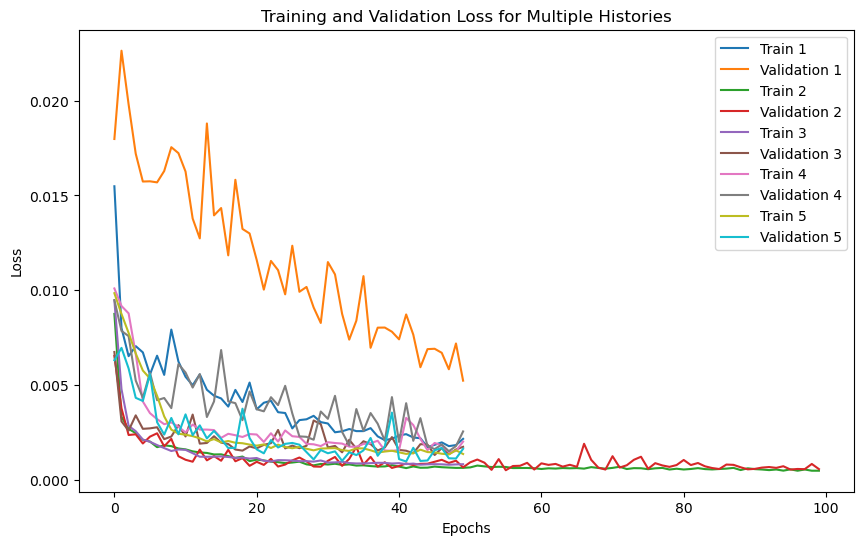

In [190]:
import matplotlib.pyplot as plt

# List of history objects
histories = [history1, history2, history3, history4, history5]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the training and validation loss
    plt.plot(train_loss, label=f'Train {i+1}')
    plt.plot(val_loss, label=f'Validation {i+1}')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Multiple Histories')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


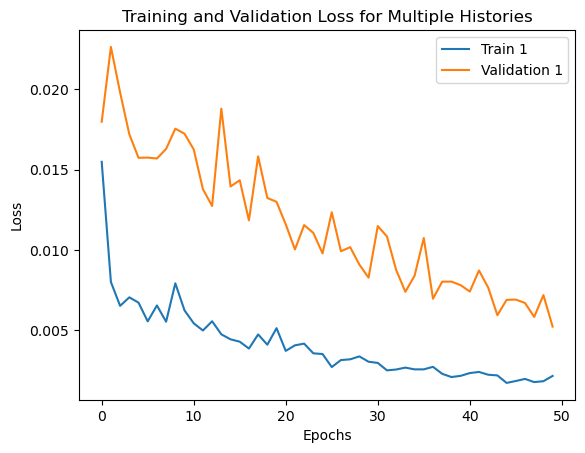

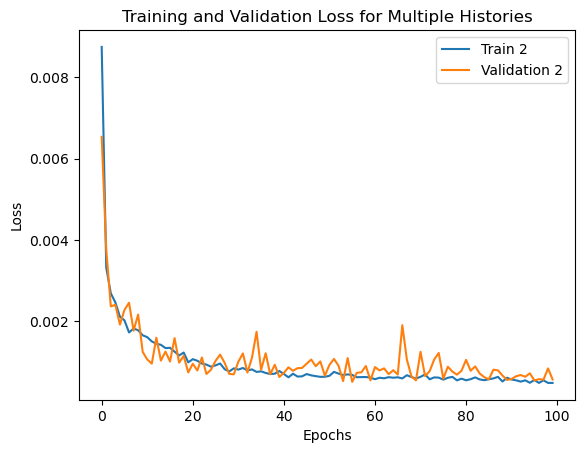

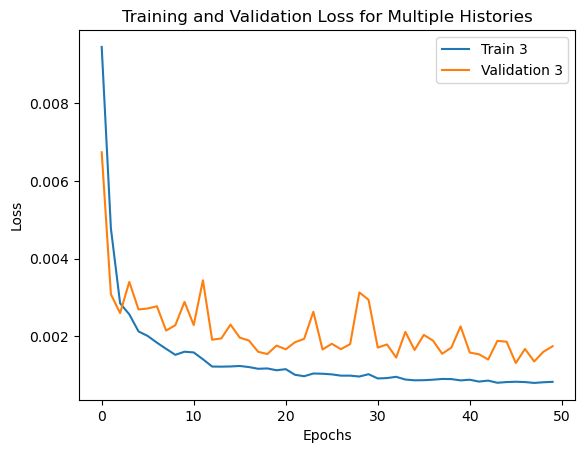

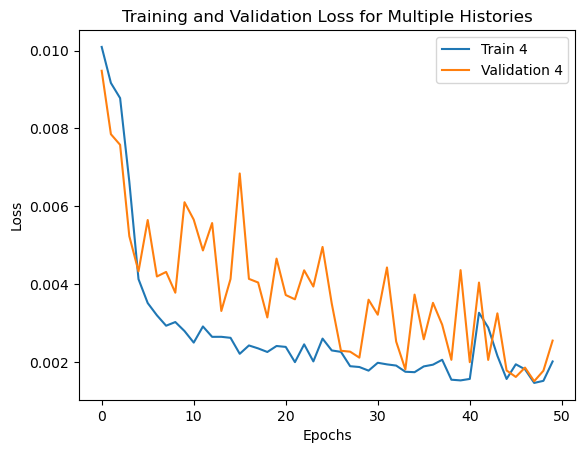

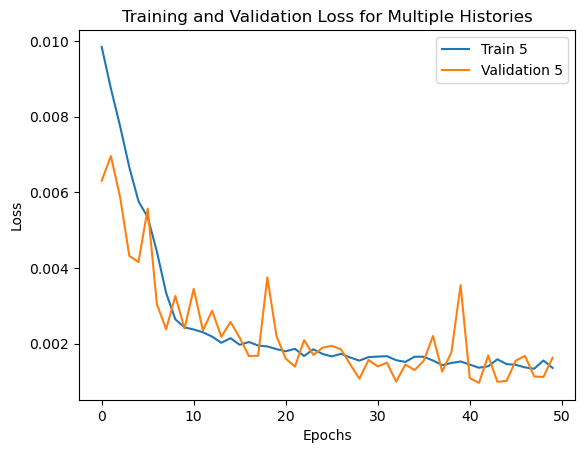

In [191]:
import matplotlib.pyplot as plt

# List of history objects
histories = [history1, history2, history3, history4, history5]

# Initialize the plot
#plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the training and validation loss
    plt.plot(train_loss, label=f'Train {i+1}')
    plt.plot(val_loss, label=f'Validation {i+1}')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Multiple Histories')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()


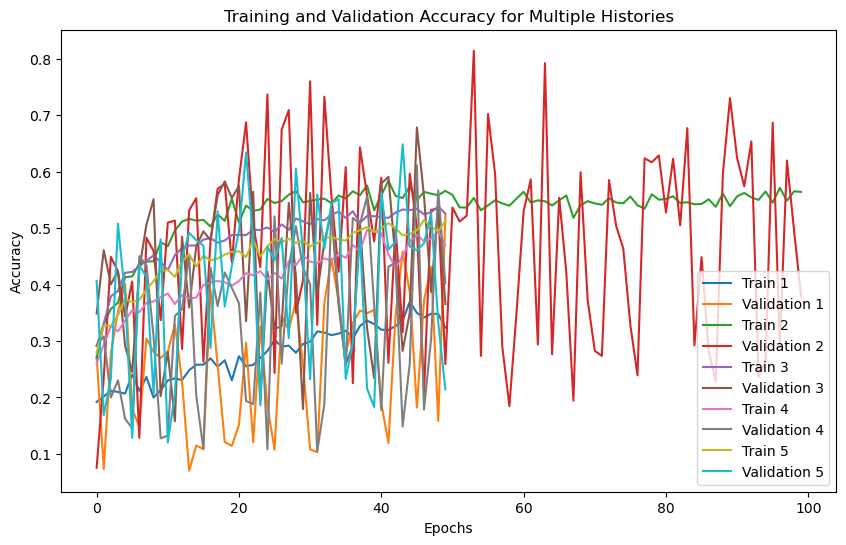

In [192]:
import matplotlib.pyplot as plt

# List of history objects
histories = [history1, history2, history3, history4, history5]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_loss = history.history['custom_accuracy']
    val_loss = history.history['val_custom_accuracy']

    # Plotting the training and validation loss
    plt.plot(train_loss, label=f'Train {i+1}')
    plt.plot(val_loss, label=f'Validation {i+1}')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Multiple Histories')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

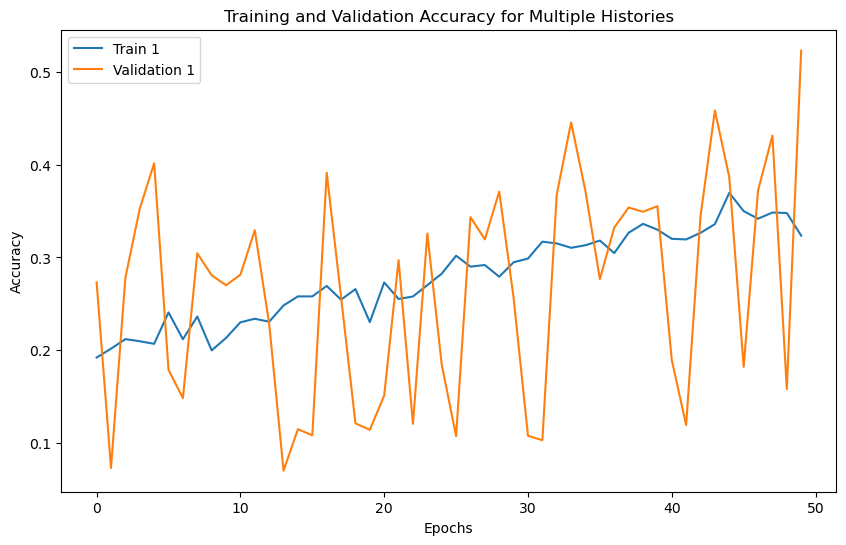

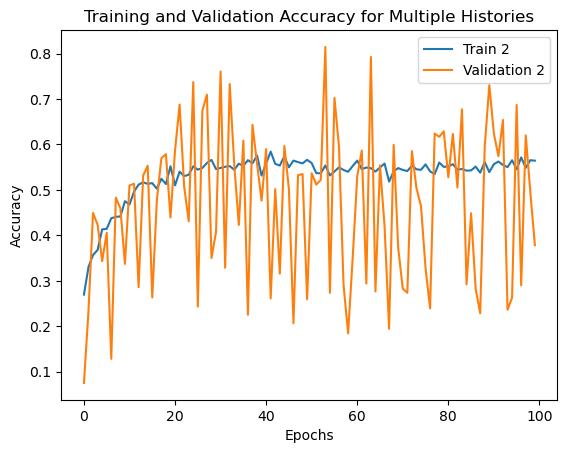

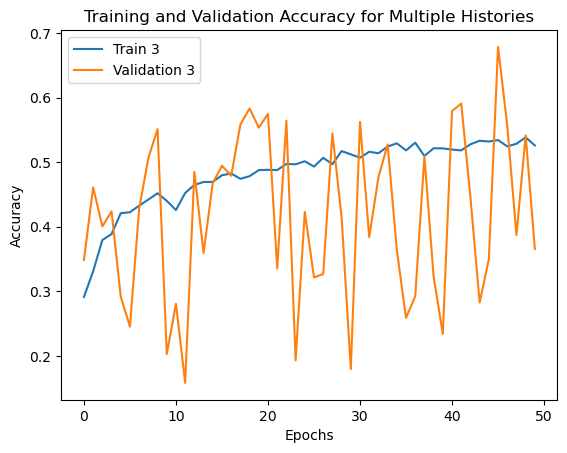

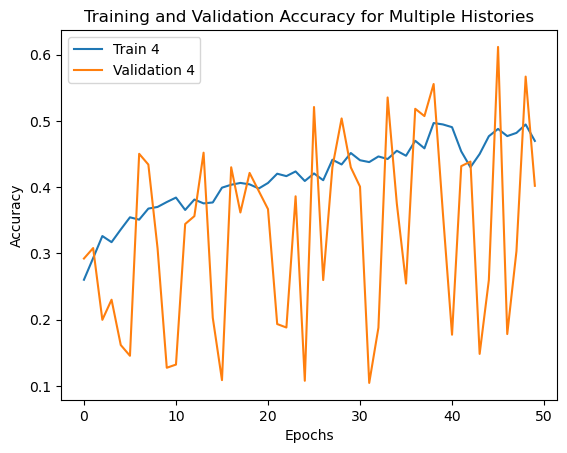

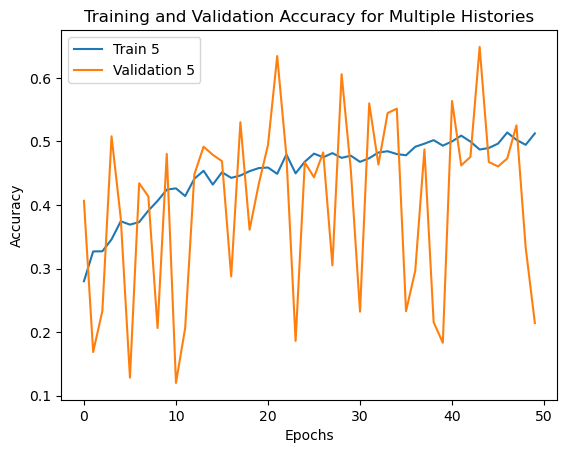

In [195]:
import matplotlib.pyplot as plt

# List of history objects
histories = [history1, history2, history3, history4, history5]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_acc = history.history['custom_accuracy'] 
    val_acc = history.history['val_custom_accuracy']

    # Plotting the training and validation accuracy
    plt.plot(train_acc, label=f'Train {i+1}')
    plt.plot(val_acc, label=f'Validation {i+1}')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Multiple Histories')
    
    # Adding a legend
    plt.legend()
    
    # Display the plot
    plt.show()


# Neighbors effect

in this part we are going to include the effect of the top 10 important neighbours of a country on the model and do the whole process again.

In [219]:
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
import math

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Load datasets
df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")
interaction_matrix = pd.read_csv("../Data/Interaction_matrix/interaction_matrix.csv")
interaction_matrix.index = interaction_matrix.columns

# delete countries we want:
exception_countries = ["CHN"]
for iso_code in exception_countries:
    df = df[df["iso_code"] != iso_code]
df = df.reset_index(drop=True)

for iso_code in exception_countries:
  interaction_matrix = interaction_matrix.drop(iso_code, axis=1)
  interaction_matrix = interaction_matrix[interaction_matrix.index != iso_code]

country_num = int(len(df["iso_code"].unique()))

# Preprocessing
df.drop(["week_no"], axis=1, inplace=True)
pop = df.iloc[0]["population"]
last_country = df.iloc[country_num*176 - 1]
print(last_country)
cnt = df["population"].value_counts()

# Identify top 10 correlated countries for each country, ignoring invalid values
top_10_neighbors = {}
valid_countries = set(interaction_matrix.index)

for country in interaction_matrix.index:
    valid_correlations = interaction_matrix.loc[country].replace([-1, 0, np.nan], np.nan).dropna()
    if len(valid_correlations) >= 10:
        top_10_neighbors[country] = valid_correlations.nlargest(10).index.tolist()
    else:
        valid_countries.remove(country)

# Normalize interaction matrix for weights
normalized_interaction_matrix = interaction_matrix.div(interaction_matrix.max(axis=1), axis=0)

# Map countries to their indices in the data
country_indices = {df.iloc[i * 176]['iso_code']: i for i in range(country_num) if df.iloc[i * 176]['iso_code'] in valid_countries}

# Initialize feature and label lists
prediction_days_count = 2
features_list = []
X_list = []
Y_list = []

# Create feature list including neighboring country features with weighted effect
for i in range(country_num):  # 234 is the total number of countries
    country = df.loc[i * 176, 'iso_code']
    if country not in valid_countries:
        continue  # Skip countries not in the valid set

    neighbors = top_10_neighbors.get(country, [])

    for j in range(176):  # 176 is the number of weeks we have
        row_list = df.loc[i * 176 + j, :].values[1:].flatten().tolist()

        for neighbor in neighbors:
            if neighbor in country_indices:
                neighbor_index = country_indices[neighbor]
                weight = normalized_interaction_matrix.loc[country, neighbor]
                weighted_features = df.loc[neighbor_index * 176 + j, :].values[1].flatten() * weight
                row_list.extend(weighted_features.tolist())

        features_list.append(row_list)

# Extend the features list for prediction days
for i in range((len(features_list) - prediction_days_count) + 1):
    fl = features_list[i]
    fl_len = len(features_list[i])
    this_population = features_list[i][fl_len - 1]
    for j in range(1, prediction_days_count):
        if this_population == features_list[i + j][fl_len - 1]:
            fl.extend(features_list[i + j])
        else:
            this_population = -1
            break
    if this_population != -1:
        X_list.append(fl)
        Y_list.append(features_list[(i + prediction_days_count) - 1][0])


iso_code                             ZWE
new_cases                           75.0
new_deaths                           2.0
new_vaccinations                     0.0
new_people_vaccinated                0.0
reproduction_rate                   0.95
stringency_index                   87.96
excess_mortality                 -1000.0
population_density                42.729
median_age                          19.6
aged_65_older                      2.822
aged_70_older                      1.882
cardiovasc_death_rate            307.846
diabetes_prevalence                 1.82
female_smokers                       1.6
male_smokers                        30.7
hospital_beds_per_thousand           1.7
life_expectancy                    61.49
human_development_index            0.571
population                    16320539.0
Name: 41007, dtype: object


In [221]:
x_df = pd.DataFrame(X_list)
n_min_max_scaler_X = preprocessing.MinMaxScaler()
x_scaled = n_min_max_scaler_X.fit_transform(x_df)

y_df = pd.DataFrame(Y_list)
n_min_max_scaler_Y = preprocessing.MinMaxScaler()
y_scaled = n_min_max_scaler_Y.fit_transform(y_df)

X_scaled_list = x_scaled.tolist()
Y_scaled_list = y_scaled.tolist()

In [222]:
X_train, X_test, Y_train, Y_test = train_test_splitter(X_scaled_list, Y_scaled_list,
                                                       country_num=country_num,
                                                       prediction_days_count=prediction_days_count,
                                                       batch_count=3,
                                                       batch_length=10)
X_tr = np.array(X_train)
y_tr = np.array(Y_train).reshape(len(Y_train))
X_te = np.array(X_test)
y_te = np.array(Y_test).reshape(len(Y_test))

In [223]:
min_val = min_max_scaler_Y.data_min_[0]
max_val = min_max_scaler_Y.data_max_[0]

# First Model

In [224]:
n_modle_1 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [225]:
n_modle_1.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [226]:
n_modle_1.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                │ (None, 64)             │         3,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,841 (15.00 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 0 (0.00 B)

In [229]:
n_history1 = n_modle_1.fit(X_tr, y_tr, validation_split=0.25, epochs=50, batch_size=50)

Epoch 1/50
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 6s 761us/step - custom_accuracy: 0.4071 - loss: 0.0147 - val_custom_accuracy: 0.5021 - val_loss: 0.0047
Epoch 2/50
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 5s 715us/step - custom_accuracy: 0.4631 - loss: 0.0053 - val_custom_accuracy: 0.6357 - val_loss: 0.0030
Epoch 3/50
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 5s 727us/step - custom_accuracy: 0.4956 - loss: 0.0039 - val_custom_accuracy: 0.3846 - val_loss: 0.0031
Epoch 4/50
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 5s 736us/step - custom_accuracy: 0.5240 - loss: 0.0031 - val_custom_accuracy: 0.6690 - val_loss: 0.0019
Epoch 5/50
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 5s 731us/step - custom_accuracy: 0.5485 - loss: 0.0025 - val_custom_accuracy: 0.7267 - val_loss: 0.0014
Epoch 6/50
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 5s 736us/step - custom_accuracy: 0.5538 - loss: 0.0023 - val_custom_accuracy: 0.5329 - val_loss: 0.0069
Epoch 7/50
6519/6519 ━━━━━━━━━━━━━━━━━━━━ 5s 719us/step - custom_accuracy: 0.5938 - loss: 0.0017 - val_custom_accuracy: 0.77

In [230]:
y_pred = n_modle_1.predict (X_te)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [231]:
loss_function(y_te, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0001699182090037133>

In [232]:
n_accuracy1 = CustomAccuracy()
n_accuracy1.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {n_accuracy1.result().numpy()}')

Custom Accuracy: 0.0


# Second Model

In [233]:
n_model_2 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [234]:
n_model_2.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [235]:
n_model_2.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 128)            │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,921 (70.00 KB)

 Non-trainable params: 0 (0.00 B)

In [236]:
n_history2 = n_model_2.fit(X_tr, y_tr, validation_split=0.25, epochs=100, batch_size=32)

Epoch 1/100
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 10s 870us/step - custom_accuracy: 0.4784 - loss: 0.0094 - val_custom_accuracy: 0.3604 - val_loss: 0.0029
Epoch 2/100
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 9s 861us/step - custom_accuracy: 0.6117 - loss: 0.0025 - val_custom_accuracy: 0.6567 - val_loss: 0.0018
Epoch 3/100
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 9s 856us/step - custom_accuracy: 0.6555 - loss: 0.0018 - val_custom_accuracy: 0.6739 - val_loss: 9.6148e-04
Epoch 4/100
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 9s 861us/step - custom_accuracy: 0.6668 - loss: 0.0016 - val_custom_accuracy: 0.4994 - val_loss: 6.7943e-04
Epoch 5/100
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 9s 854us/step - custom_accuracy: 0.6747 - loss: 0.0013 - val_custom_accuracy: 0.7050 - val_loss: 0.0011
Epoch 6/100
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 9s 838us/step - custom_accuracy: 0.6756 - loss: 0.0013 - val_custom_accuracy: 0.8039 - val_loss: 5.4840e-04
Epoch 7/100
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 9s 862us/step - custom_accuracy: 0.6888 - loss: 

In [237]:
y_pred = n_model_2.predict (X_te)
loss_function(y_te, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<tf.Tensor: shape=(), dtype=float64, numpy=0.00019937829279098506>

In [238]:
n_accuracy2 = CustomAccuracy()
n_accuracy2.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {n_accuracy2.result().numpy()}')

Custom Accuracy: 0.0


# Third Model

In [251]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

In [252]:
n_model_3 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='leaky_relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [253]:
n_model_3.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [254]:
n_model_3.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 56, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 26, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │        26,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

In [256]:
n_history3 = n_model_3.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=20, batch_size=32)

Epoch 1/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - custom_accuracy: 0.7435 - loss: 7.3410e-04 - val_custom_accuracy: 0.6153 - val_loss: 7.1997e-04
Epoch 2/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - custom_accuracy: 0.7508 - loss: 6.9804e-04 - val_custom_accuracy: 0.8253 - val_loss: 6.8383e-04
Epoch 3/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - custom_accuracy: 0.7525 - loss: 6.7764e-04 - val_custom_accuracy: 0.7694 - val_loss: 6.9127e-04
Epoch 4/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - custom_accuracy: 0.7518 - loss: 6.8769e-04 - val_custom_accuracy: 0.6620 - val_loss: 6.4053e-04
Epoch 5/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - custom_accuracy: 0.7484 - loss: 6.9529e-04 - val_custom_accuracy: 0.7653 - val_loss: 5.3612e-04
Epoch 6/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - custom_accuracy: 0.7537 - loss: 6.6749e-04 - val_custom_accuracy: 0.7197 - val_loss: 5.8675e-04
Epoch 7/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - custom_accu

In [257]:
y_pred = n_model_3.predict (X_te)
loss_function(y_te, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.0008217851834929836>

In [267]:
n_accuracy3 = CustomAccuracy()
n_accuracy3.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {n_accuracy3.result().numpy()}')

Custom Accuracy: 0.0


# Forth Model

In [272]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

In [273]:
n_model_4 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.SimpleRNN(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])

In [274]:
n_model_4.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [275]:
n_model_4.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [276]:
n_history4 = n_model_4.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=20, batch_size=32)

Epoch 1/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - custom_accuracy: 0.4858 - loss: 0.0263 - val_custom_accuracy: 0.5652 - val_loss: 0.0047
Epoch 2/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - custom_accuracy: 0.5694 - loss: 0.0069 - val_custom_accuracy: 0.6745 - val_loss: 0.0039
Epoch 3/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - custom_accuracy: 0.5909 - loss: 0.0061 - val_custom_accuracy: 0.4220 - val_loss: 0.0032
Epoch 4/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - custom_accuracy: 0.5976 - loss: 0.0060 - val_custom_accuracy: 0.6772 - val_loss: 0.0026
Epoch 5/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - custom_accuracy: 0.6243 - loss: 0.0038 - val_custom_accuracy: 0.7143 - val_loss: 0.0024
Epoch 6/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - custom_accuracy: 0.6292 - loss: 0.0038 - val_custom_accuracy: 0.7160 - val_loss: 0.0026
Epoch 7/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - custom_accuracy: 0.6449 - loss: 0.0033 - val_custom_accurac

In [277]:
y_pred = n_model_4.predict (X_te)
loss_function(y_te, y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.0009910155314008877>

In [278]:
n_accuracy4 = CustomAccuracy()
n_accuracy4.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {n_accuracy4.result().numpy()}')

Custom Accuracy: 0.0


# Fifth Model

In [279]:
X_tr_reshaped = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te_reshaped = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

In [280]:
n_model_5 = keras.Sequential([
    keras.Input(shape=(X_tr.shape[1], 1)),
    keras.layers.LSTM(64, activation='relu'),
    keras.layers.Dense(1)  # No activation function for regression
])


In [281]:
n_model_5.compile(optimizer='adam',
              metrics=[CustomAccuracy()],
              loss=loss_function)

In [282]:
n_model_5.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [283]:
n_history5 = n_model_5.fit(X_tr_reshaped, y_tr, validation_split=0.25, epochs=20, batch_size=32)

Epoch 1/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 111s 11ms/step - custom_accuracy: 0.5075 - loss: 98.3019 - val_custom_accuracy: 0.4857 - val_loss: 0.0075
Epoch 2/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 108s 11ms/step - custom_accuracy: 0.5397 - loss: 0.0110 - val_custom_accuracy: 0.5956 - val_loss: 0.0058
Epoch 3/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 109s 11ms/step - custom_accuracy: 0.5503 - loss: 0.0121 - val_custom_accuracy: 0.6129 - val_loss: 0.0060
Epoch 4/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 109s 11ms/step - custom_accuracy: 0.5739 - loss: 0.0095 - val_custom_accuracy: 0.6791 - val_loss: 0.0041
Epoch 5/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 108s 11ms/step - custom_accuracy: 0.6047 - loss: 0.0081 - val_custom_accuracy: 0.4929 - val_loss: 0.0113
Epoch 6/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 109s 11ms/step - custom_accuracy: 0.5972 - loss: 0.0064 - val_custom_accuracy: 0.7145 - val_loss: 0.0028
Epoch 7/20
10185/10185 ━━━━━━━━━━━━━━━━━━━━ 109s 11ms/step - custom_accuracy: 0.6265 - loss: 0.0049 - val

In [284]:
y_pred = n_model_5.predict (X_te)
loss_function(tf.convert_to_tensor(y_te), y_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.0005238996142241604>

In [285]:
n_accuracy5 = CustomAccuracy()
n_accuracy5.update_state(tf.cast(y_te, tf.float32), y_pred)
print(f'Custom Accuracy: {n_accuracy5.result().numpy()}')

Custom Accuracy: 0.0


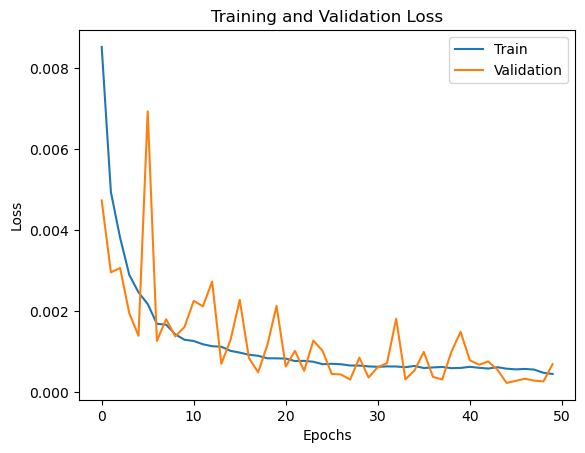

In [286]:
import matplotlib.pyplot as plt

# Assuming history1 is an object that has a history attribute with 'loss' and 'val_loss'
train_loss = n_history1.history['loss']
val_loss = n_history1.history['val_loss']

# Plotting the training and validation loss
plt.plot(train_loss)
plt.plot(val_loss)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Adding a legend
plt.legend(["Train", "Validation"])

# Display the plot
plt.show()

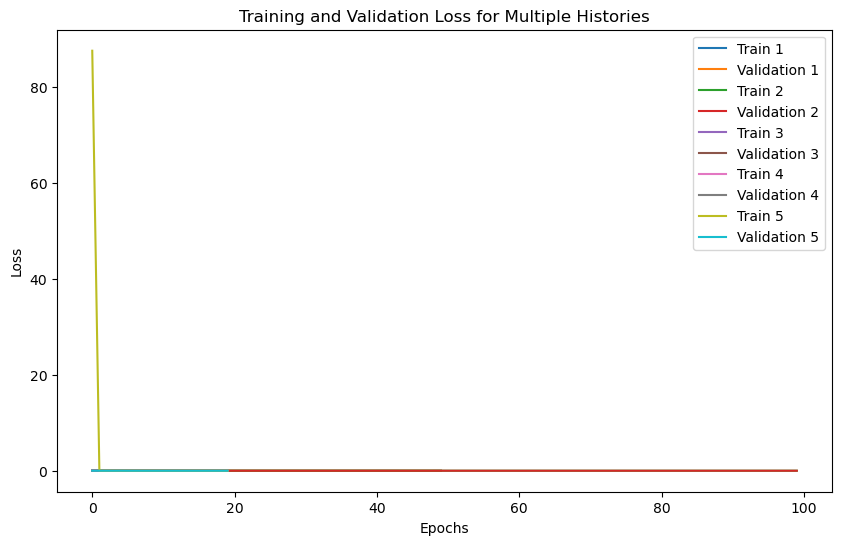

In [287]:
import matplotlib.pyplot as plt

# List of history objects
histories = [n_history1, n_history2, n_history3, n_history4, n_history5]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the training and validation loss
    plt.plot(train_loss, label=f'Train {i+1}')
    plt.plot(val_loss, label=f'Validation {i+1}')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Multiple Histories')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


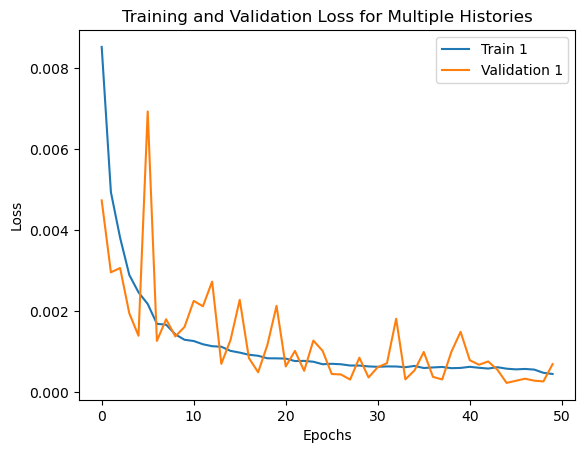

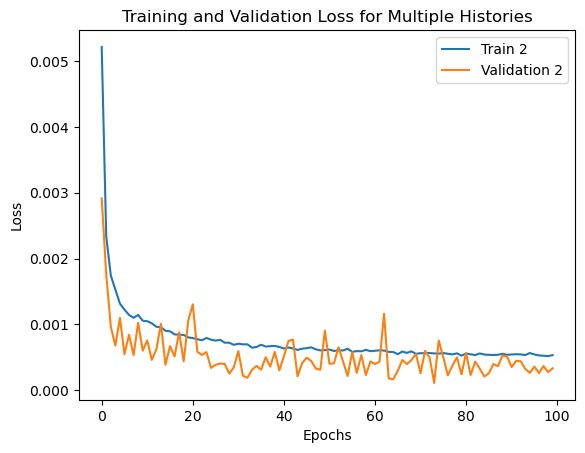

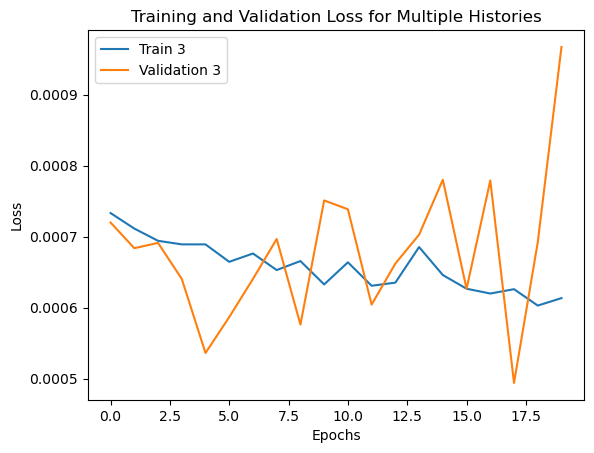

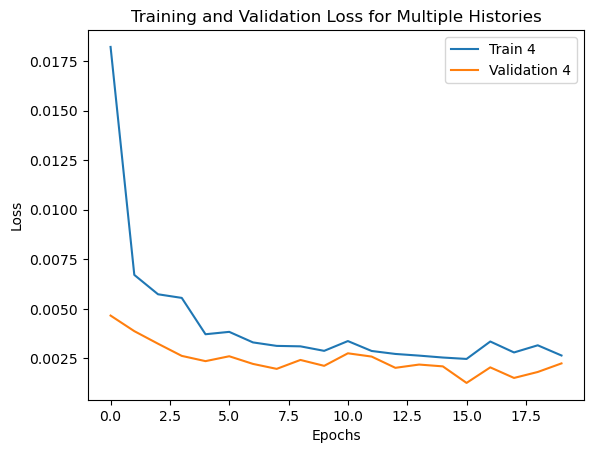

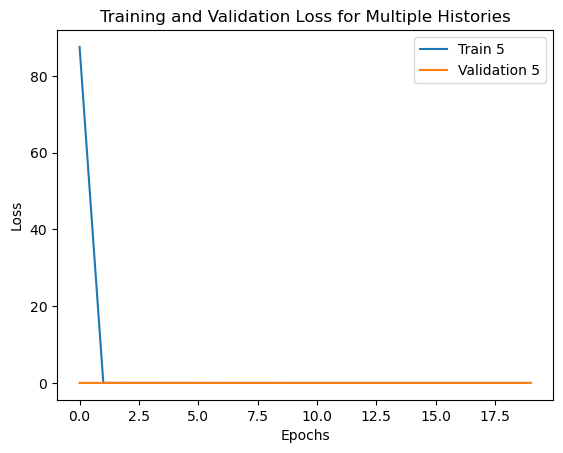

In [288]:
import matplotlib.pyplot as plt

# List of history objects
histories = [n_history1, n_history2, n_history3, n_history4, n_history5]

# Initialize the plot
#plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the training and validation loss
    plt.plot(train_loss, label=f'Train {i+1}')
    plt.plot(val_loss, label=f'Validation {i+1}')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Multiple Histories')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()


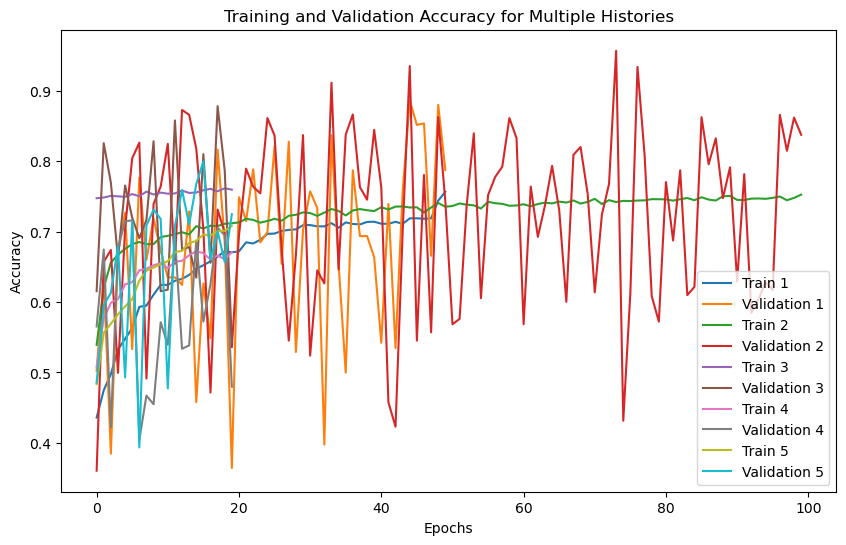

In [289]:
import matplotlib.pyplot as plt

# List of history objects
histories = [n_history1, n_history2, n_history3, n_history4, n_history5]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_loss = history.history['custom_accuracy']
    val_loss = history.history['val_custom_accuracy']

    # Plotting the training and validation loss
    plt.plot(train_loss, label=f'Train {i+1}')
    plt.plot(val_loss, label=f'Validation {i+1}')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Multiple Histories')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

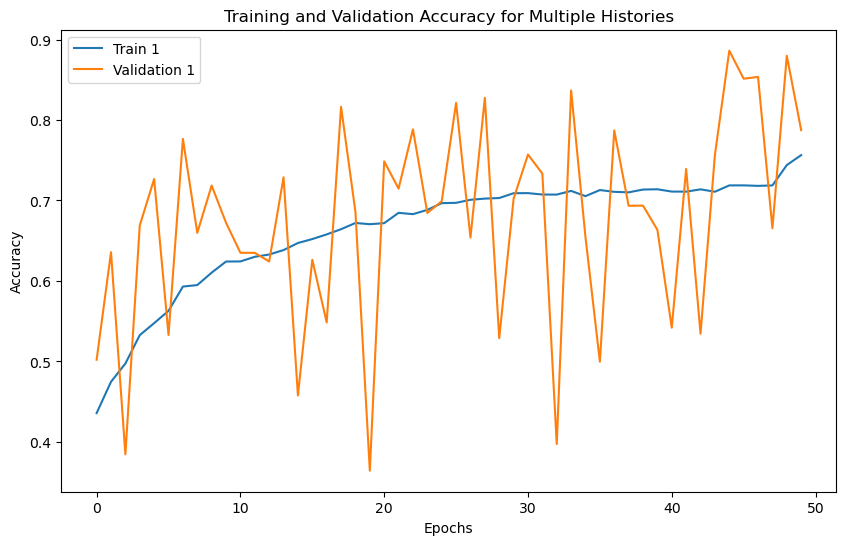

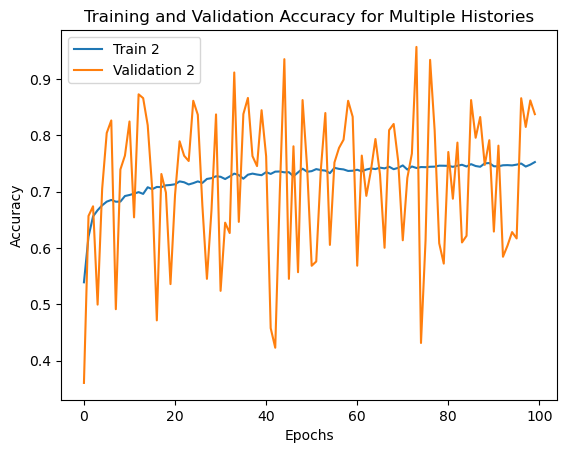

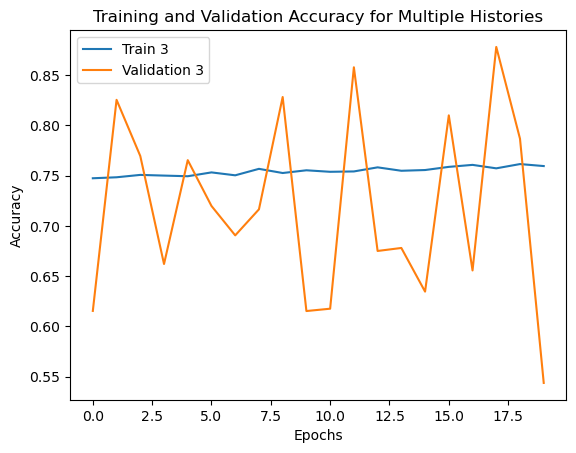

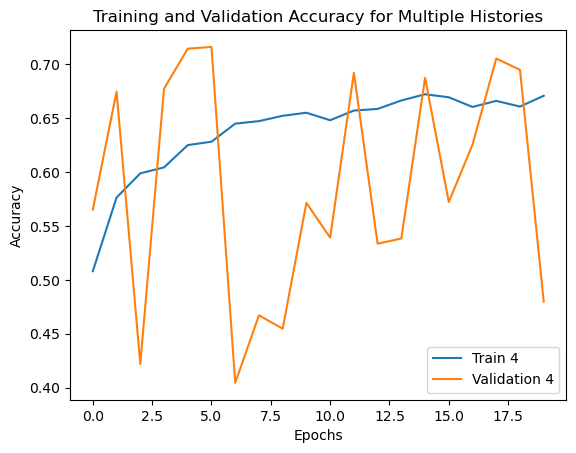

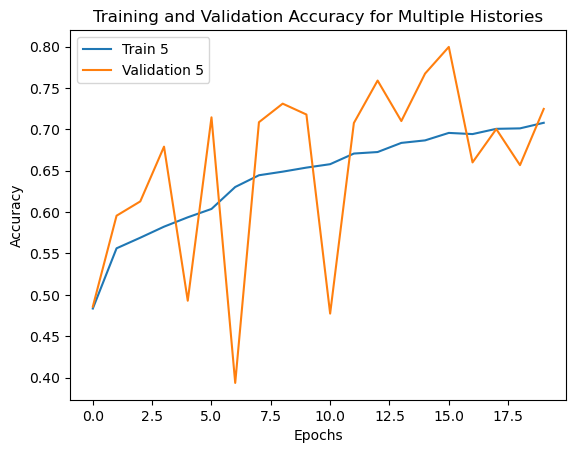

In [290]:
import matplotlib.pyplot as plt

# List of history objects
histories = [n_history1, n_history2, n_history3, n_history4, n_history5]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each history object
for i, history in enumerate(histories):
    train_acc = history.history['custom_accuracy'] 
    val_acc = history.history['val_custom_accuracy']

    # Plotting the training and validation accuracy
    plt.plot(train_acc, label=f'Train {i+1}')
    plt.plot(val_acc, label=f'Validation {i+1}')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Multiple Histories')
    
    # Adding a legend
    plt.legend()
    
    # Display the plot
    plt.show()